In [1]:
import ee
import geemap

In [2]:
Map = geemap.Map()

In [3]:
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [4]:
#get the NLCD image 2016
NLCD = ee.Image('USGS/NLCD/NLCD2016').select('landcover')
Map.addLayer(NLCD, {}, 'NLCD')

In [5]:
#look at the metadata
NLCD_meta = ee.FeatureCollection('users/giswqs/landcover/NLCD2016_metadata')
Map.addLayer(NLCD_meta, {}, 'NLCD Metadata')

In [6]:
#create a point for huntsville
point = ee.Geometry.Point([-86.58, 34.72])

In [7]:
#filter metadata to huntsville point
metadata = NLCD_meta.filterBounds(point).first()
region = metadata.geometry()

In [8]:
metadata.get('2016on_bas').getInfo()

'LC08_2016283'

In [9]:
doy = metadata.get('2016on_bas').getInfo().replace('LC08_', '')
doy

'2016283'

In [10]:
ee.Date.parse('YYYYDDD', doy).format('YYYY-MM-dd').getInfo()

'2016-10-09'

In [11]:
#filter landsat imagery by the point 
startdate = ee.Date.parse('YYYYDDD', doy)
enddate = startdate.advance(1, 'day')

In [12]:
image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(point).filterDate(startdate, enddate).first().select('B[1-7]').clip(region)

In [13]:
vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}

In [14]:
Map.centerObject(point, 8)
Map.addLayer(image, vis_params, 'landsat-8')
Map

Map(center=[34.720000000000006, -86.58], controls=(WidgetControl(options=['position', 'transparent_bg'], widge…

In [15]:
#clip the NLCD to the study region. 
nlcd_raw = NLCD.clip(region)
Map.addLayer(nlcd_raw, {}, 'NLCD_clip')

In [16]:
#get the class values 
raw_class_values = nlcd_raw.get('landcover_class_values').getInfo()
print(raw_class_values)

[11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 51, 52, 71, 72, 73, 74, 81, 82, 90, 95]


In [17]:
#remap the classes from 0-len of class values list. 
n_classes = len(raw_class_values)
new_class_values = list(range(0, n_classes))
new_class_values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [18]:
class_palette = nlcd_raw.get('landcover_class_palette').getInfo()
print(class_palette)

['476ba1', 'd1defa', 'decaca', 'd99482', 'ee0000', 'ab0000', 'b3aea3', '68ab63', '1c6330', 'b5ca8f', 'a68c30', 'ccba7d', 'e3e3c2', 'caca78', '99c247', '78ae94', 'dcd93d', 'ab7028', 'bad9eb', '70a3ba']


In [19]:
#create new, remaped landcover bands
nlcd = nlcd_raw.remap(raw_class_values, new_class_values).select(['remapped'], ['landcover'])
nlcd = nlcd.set('landcover_class_values', new_class_values)
nlcd = nlcd.set('landcover_class_palette', class_palette)

In [20]:
Map.addLayer(nlcd, {}, 'NLCD_remaped')
Map

Map(center=[34.720000000000006, -86.58], controls=(WidgetControl(options=['position', 'transparent_bg'], widge…

In [21]:
#make the training data 
points = nlcd.sample(**{
    'region': region,
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True
})

Map.addLayer(points, {}, 'training')

In [22]:
points.size().getInfo()

5000

In [23]:
print(points.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-85.76019437562952, 34.24361130908887]}, 'id': '0', 'properties': {'landcover': 8}}


In [24]:
#create the training data
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

#landcover label
label = 'landcover'

#sample the imagery for training data
sample = image.select(bands).sampleRegions(**{
    'collection': points,
    'properties': [label],
    'scale': 30,
})

#add column of numbers to randomize by 
sample = sample.randomColumn()

#train test split for validation
split = 0.7

training = sample.filter(ee.Filter.lt('random', split))
validation = sample.filter(ee.Filter.gte('random', split))


In [25]:
print(training.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '1_0', 'properties': {'B1': 110, 'B2': 140, 'B3': 341, 'B4': 227, 'B5': 2843, 'B6': 1360, 'B7': 535, 'landcover': 7, 'random': 0.16635075374547859}}


In [26]:
print(validation.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '0_0', 'properties': {'B1': 83, 'B2': 113, 'B3': 279, 'B4': 190, 'B5': 2442, 'B6': 929, 'B7': 368, 'landcover': 8, 'random': 0.8142236509732306}}


In [27]:
#train the classifier 
classifier = ee.Classifier.smileRandomForest(10).train(training, label, bands)

In [28]:
print(classifier.getInfo())

{'type': 'Classifier.train', 'classifier': {'type': 'Classifier.smileRandomForest', 'numberOfTrees': 10}, 'features': {'type': 'FeatureCollection', 'columns': {'random': '<any>'}}, 'classProperty': 'landcover', 'inputProperties': ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']}


In [29]:
result = image.select(bands).classify(classifier)
Map.addLayer(result.randomVisualizer(), {}, 'classified')

In [30]:
Map

Map(center=[34.720000000000006, -86.58], controls=(WidgetControl(options=['position', 'transparent_bg'], widge…

In [31]:
#get the class values and palette and set them to the image 
class_values = nlcd.get('landcover_class_values').getInfo()
print(class_values)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [32]:
class_palette = nlcd.get('landcover_class_palette').getInfo()
print(class_palette)

['476ba1', 'd1defa', 'decaca', 'd99482', 'ee0000', 'ab0000', 'b3aea3', '68ab63', '1c6330', 'b5ca8f', 'a68c30', 'ccba7d', 'e3e3c2', 'caca78', '99c247', '78ae94', 'dcd93d', 'ab7028', 'bad9eb', '70a3ba']


In [33]:
landcover = result.set('classification_class_values', class_values)
landcover = landcover.set('classification_class_palette', class_palette)

In [34]:
Map.addLayer(landcover, {}, 'Land Cover - Random Forest')

In [35]:
print('Change Opacity: ')
cluster_layer = Map.layers[-1]
cluster_layer.interact(opacity=(0, 1, 0.1))

Change Opacity: 


Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0),))

In [36]:
#add a legend 
Map.add_legend(builtin_legend='NLCD')
#Map.remove_legends()

In [37]:
train_acc = classifier.confusionMatrix()

In [38]:
train_acc.getInfo()

[[101, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 178, 2, 0, 0, 0, 9, 1, 1, 0, 0, 0, 0, 0, 0, 13, 1, 0, 0],
 [0, 0, 1, 91, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
 [0, 0, 0, 3, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 1337, 2, 4, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
 [0, 0, 2, 0, 0, 0, 0, 11, 227, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 39, 8, 214, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 9, 2, 0, 0, 70, 0, 0, 0, 0, 2, 0, 0, 0],
 [0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 67, 0, 0, 0, 10, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [39]:
#sum of diagonal divided by all numbers
train_acc.accuracy().getInfo()

0.941410693970421

In [40]:
#kappa - 0-1, 1 is better suggesting that it is better than random
train_acc.kappa().getInfo()

0.9241130354261963

In [41]:
#percentage of correct - percent incorrect for each class of tree
train_acc.producersAccuracy().getInfo()[7:10]
#train_acc.producersAccuracy().getInfo()
#Deciduous, Evergreen, Mixed

[[0.988905325443787], [0.9227642276422764], [0.8136882129277566]]

In [42]:
validated = validation.classify(classifier) 

In [43]:
validated.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_0',
 'properties': {'B1': 83,
  'B2': 113,
  'B3': 279,
  'B4': 190,
  'B5': 2442,
  'B6': 929,
  'B7': 368,
  'classification': 8,
  'landcover': 8,
  'random': 0.8142236509732306}}

In [44]:
randomForrest_test_accuracy = validated.errorMatrix('landcover', 'classification')

In [45]:
randomForrest_validation = randomForrest_test_accuracy.accuracy().getInfo()
randomForrest_validation

0.6030997304582211

In [46]:
rfkappa = randomForrest_test_accuracy.kappa().getInfo()
rfkappa

0.46445392222758003

In [47]:
rfproducersacc = randomForrest_test_accuracy.producersAccuracy().getInfo()[7:10]
#rfproducersacc = randomForrest_test_accuracy.producersAccuracy().getInfo()
rfproducersacc

[[0.8754512635379061], [0.5137614678899083], [0.08943089430894309]]

In [48]:
#compare to a different model - smilecart regressor
classifier2 = ee.Classifier.smileCart().train(training, label, bands)

In [49]:
result2 = image.select(bands).classify(classifier2)

In [50]:
landcover2 = result2.set('classification_class_values', class_values)
landcover2 = landcover2.set('classification_class_palette', class_palette)

In [51]:
Map.addLayer(landcover2, {}, 'Landcover - SmileCart')

In [52]:
Map

Map(center=[34.720000000000006, -86.58], controls=(WidgetControl(options=['position', 'transparent_bg'], widge…

In [53]:
#accuracy
train_acc2 = classifier2.confusionMatrix()
train_acc2.accuracy().getInfo()

1

In [54]:
validation = validation.classify(classifier2)

In [55]:
smile_cart_test_accuracy = validation.errorMatrix('landcover', 'classification')

In [56]:
smilecart_validation = smile_cart_test_accuracy.accuracy().getInfo()
smilecart_validation

0.4946091644204852

In [57]:
smilekappa = smile_cart_test_accuracy.kappa().getInfo()
smilekappa

0.35995307472677246

In [58]:
smileproducersacc = smile_cart_test_accuracy.producersAccuracy().getInfo()[7:10]
smileproducersacc = [i for sublist in smileproducersacc for i in sublist]
smile_dict = {'Deciduous Forest': smileproducersacc[0], 'Evergreen Forest': smileproducersacc[1], 'Mixed Forest': smileproducersacc[2], 'Kappa': smilekappa}
smile_dict

{'Deciduous Forest': 0.6787003610108303,
 'Evergreen Forest': 0.46788990825688076,
 'Mixed Forest': 0.17073170731707318,
 'Kappa': 0.35995307472677246}

In [59]:
import pandas as pd
smile_df = pd.DataFrame(data=smile_dict, index=[0])

Text(0.5, 1.0, 'SmileCart Producers Accuracy')

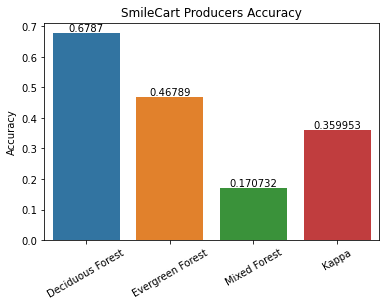

In [60]:
import seaborn as sns
barplot = sns.barplot(data=smile_df)
barplot.set_xticklabels(labels=smile_df.columns, rotation=30)
barplot.set_ylabel('Accuracy')
barplot.bar_label(barplot.containers[0])
barplot.set_title('SmileCart Producers Accuracy')

In [61]:
rfproducersacc = [i for sublist in rfproducersacc for i in sublist]
rf_dict = {'Deciduous Forest': rfproducersacc[0], 'Evergreen Forest': rfproducersacc[1], 'Mixed Forest': rfproducersacc[2], 'Kappa': rfkappa}
rf_dict

{'Deciduous Forest': 0.8754512635379061,
 'Evergreen Forest': 0.5137614678899083,
 'Mixed Forest': 0.08943089430894309,
 'Kappa': 0.46445392222758003}

In [62]:
rf_df = pd.DataFrame(data=rf_dict, index=[0])

Text(0.5, 1.0, 'Random Forest (10 Trees) Producers Accuracy')

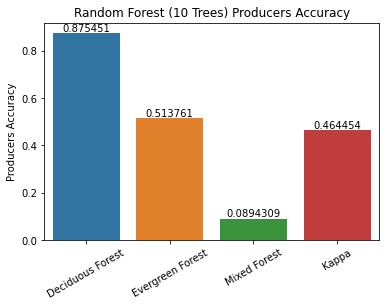

In [63]:
barplot = sns.barplot(data=rf_df)
barplot.set_xticklabels(labels=rf_df.columns, rotation=30)
barplot.set_ylabel('Producers Accuracy')
barplot.bar_label(barplot.containers[0])
barplot.set_title('Random Forest (10 Trees) Producers Accuracy')

In [64]:
#lets test more trees for rf and see what happens
classifier3 = ee.Classifier.smileRandomForest(100).train(training, label, bands)

In [65]:
train_acc3 = classifier3.confusionMatrix()
train_acc3.accuracy().getInfo()

0.9928896473265074

In [66]:
validation = validation.classify(classifier3)

In [67]:
rf100_test_accuracy = validation.errorMatrix('landcover', 'classification')
rf100_test_accuracy.accuracy().getInfo()

0.6300539083557951

In [68]:
rf100kappa = rf100_test_accuracy.kappa().getInfo()
rf100kappa

0.49621535118609983

In [69]:
rf100producersacc = rf100_test_accuracy.producersAccuracy().getInfo()[7:10]
rf100producersacc

[[0.9097472924187726], [0.5871559633027523], [0.06504065040650407]]

In [70]:
rf100producersacc = [i for sublist in rf100producersacc for i in sublist]
rf100_dict = {'Deciduous Forest': rf100producersacc[0], 'Evergreen Forest': rf100producersacc[1], 'Mixed Forest': rf100producersacc[2], 'Kappa': rf100kappa}
rf100_dict

{'Deciduous Forest': 0.9097472924187726,
 'Evergreen Forest': 0.5871559633027523,
 'Mixed Forest': 0.06504065040650407,
 'Kappa': 0.49621535118609983}

In [71]:
rf100_df = pd.DataFrame(data=rf100_dict, index=[0])

Text(0.5, 1.0, 'Random Forest (100 Trees) Producers Accuracy')

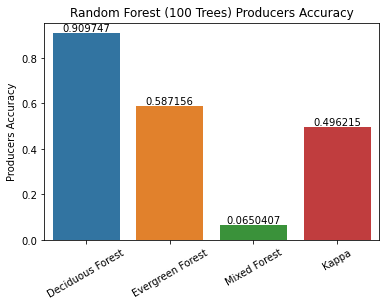

In [72]:
barplot = sns.barplot(data=rf100_df)
barplot.set_xticklabels(labels=rf100_df.columns, rotation=30)
barplot.set_ylabel('Producers Accuracy')
barplot.bar_label(barplot.containers[0])
barplot.set_title('Random Forest (100 Trees) Producers Accuracy')